# Scene Classification with CNNs: Architecture Comparison and Hyperparameter Tuning

This notebook implements Convolutional Neural Networks (CNNs) to classify indoor scenes from the MIT Places dataset. We compare different architectures and perform hyperparameter tuning to identify the best-performing model.


## Environment and Reproducibility:
Seed everything, fix cuDNN, mount Google Drive.

In [ ]:
import torch, torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision.datasets import ImageFolder
from PIL import Image
from google.colab import drive
import os, zipfile, random, shutil, time, glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict, namedtuple

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print('Device:', device)

Device: cuda


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Preparation

We load and preprocess a subset of the MIT Places dataset, focusing specifically on three scene classes: `library-indoor`, `museum-indoor`, and `shopping_mall-indoor`. The dataset is balanced with 5,000 training images per class and 100 test images per class. Images are standardized to a resolution of 256 × 256 pixels. A stratified 90/10 split is used to create training and validation subsets.


In [ ]:
zip_path = "/content/drive/My Drive/dataset/Comp6721_Project_Dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

train_dir = "/content/Training"
test_dir = "/content/Test"
print("Train subfolders (classes):", os.listdir(train_dir))
print("Test subfolders (classes):", os.listdir(test_dir))

Train subfolders (classes): ['shopping_mall-indoor', 'museum-indoor', 'library-indoor']
Test subfolders (classes): ['shopping_mall-indoor', 'museum-indoor', 'library-indoor']


## Data Augmentation and Preprocessing

To enhance model robustness and reduce overfitting, we apply extensive data augmentation techniques including random resized cropping, horizontal flips, color jittering, rotations, and random erasing. Images are normalized based on the standard ImageNet RGB channel mean and standard deviation. Validation and test images receive only normalization (without augmentations) to evaluate generalization on unaltered data.


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.15))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset  = ImageFolder(test_dir , transform=test_transform)
class_names   = train_dataset.classes
print('Classes:', class_names)

Classes: ['library-indoor', 'museum-indoor', 'shopping_mall-indoor']


## Train/Validation Split Stratified 90 / 10 split with fixed random-seed (42).

In [ ]:
idx_all   = list(range(len(train_dataset)))
labels_np = np.array(train_dataset.targets)
train_idx, val_idx = train_test_split(idx_all, test_size=0.10, stratify=labels_np, random_state=SEED)

train_split = Subset(train_dataset, train_idx)
#val_split   = Subset(ImageFolder(train_dir, transform=test_transform), val_idx)  # val uses *test* transforms
val_split = Subset(train_dataset, val_idx)
val_split.dataset.transform = test_transform  # Override transform

batch_size = 64
def seed_worker(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
g = torch.Generator().manual_seed(SEED)

train_loader = DataLoader(
    train_split,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

validation_loader = DataLoader(
    val_split,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=300,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"Train: {len(train_split)} | Val: {len(val_split)} | Test: {len(test_dataset)}")

Train: 13500 | Val: 1500 | Test: 300


## CNN Architectures

We evaluate three CNN architectures:

1. **Baseline CNN (`CNN4x4`)**: A compact CNN with 4 convolutional blocks, adaptive pooling, and a fully-connected classifier.
2. **Compact VGG**: A deeper architecture inspired by the VGG model, utilizing repeated convolutional blocks.
3. **Hybrid Model**: Combines elements from the above architectures, designed to balance model complexity and efficiency.

All models are implemented from scratch in PyTorch without pre-trained weights.


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Adaptive pooling handles ANY input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
class CompactVGG(nn.Module):
    def __init__(self, num_classes: int = 3):
        super().__init__()

        def vgg_block(in_c: int, out_c: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.MaxPool2d(2)  # halves H and W
            )

        self.features = nn.Sequential(
            vgg_block(3,   32),   # 256 → 128
            vgg_block(32,  64),   # 128 →  64
            vgg_block(64, 128),   #  64 →  32
            vgg_block(128,256)    #  32 →  16
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))     # 256 × 1 × 1
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)     # [B,256,16,16]
        x = self.gap(x).flatten(1)
        x = self.classifier(x)
        return x

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            # Stage 1 (High Resolution)
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128

            # Stage 2-4 (Lower Resolution)
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).flatten(1)
        return self.classifier(x)

## Training Setup

The models are trained using the Adam optimizer with label-smoothed cross-entropy loss. We employ a learning rate scheduler (`ReduceLROnPlateau`) to dynamically reduce the learning rate when validation accuracy plateaus. Early stopping is implemented to halt training if validation performance doesn't improve for 6 consecutive epochs, saving the best-performing model checkpoint.



In [ ]:
# Training loop
def train(model, criterion, optimizer, scheduler=None, num_epochs=40, patience=6):
    best_acc, patience_counter = 0.0, 0
    best_ckpt = None
    start_time = time.time()
    for ep in range(1, num_epochs+1):
        # Train
        model.train()
        running_loss, correct, total = 0, 0, 0
        for inputs,labels in train_loader:
            inputs,labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*inputs.size(0)
            pred = outputs.argmax(1)
            correct += (pred==labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss/total
        train_acc  = correct/total

        # Validate
        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                v_loss += criterion(outputs, labels).item()*inputs.size(0)
                v_correct += (outputs.argmax(1)==labels).sum().item()
                v_total += labels.size(0)

        val_loss = v_loss / v_total
        val_acc   = v_correct/v_total
        scheduler.step(val_acc)

        # Checkpoint on best val-acc
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            tag   = f"bs{batch_size}_lr{optimizer.param_groups[0]['lr']:.0e}"
            fname = f"{model.__class__.__name__}_{tag}.pth"
            torch.save(model.state_dict(), fname)
            best_ckpt = fname
        else:
            patience_counter += 1


        print(f"Epoch {ep:2d}/{num_epochs} | "
              f"lr {optimizer.param_groups[0]['lr']:.2e} | "
              f"train loss {train_loss:.4f} acc {train_acc*100:5.1f}% | "
              f"valid loss {val_loss:.4f} acc {val_acc*100:5.1f}% | "
              f"best accuracy {best_acc*100:5.1f}%")

        if patience_counter >= patience:
            print("Early stopping")
            break

    elapsed = (time.time() - start_time) / 60
    print(f"Training finished in {elapsed:.1f} min.")
    return best_acc, best_ckpt

## Model Evaluation

The evaluation function computes classification accuracy, precision, recall, and F1-score on the test set. It also visualizes results through a confusion matrix to better interpret class-specific model performance.


In [ ]:
def evaluate(model, checkpoint_path, loader, desc="TEST"):
    # Restore weights and switch to eval mode
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device).eval()

    # Forward pass on the entire loader
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device)).cpu()
            y_pred.extend(outputs.argmax(1).numpy())
            y_true.extend(labels.numpy())

    # Text report
    print(f"\n{desc} – classification metrics")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{desc} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    # scalar accuracy
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return acc

## Baseline Results (Default Hyperparameters)

We initially train all architectures using identical hyperparameters to establish a performance baseline. Validation accuracy is monitored to select the best model checkpoint for each architecture.

* **Optimizer**  Adam   (lr = 1 × 10-3, weight-decay = 1 × 10-4)  
* **Scheduler**  ReduceLROnPlateau (mode =max, factor = 0.5, patience = 3)  
* **Loss**       Cross-Entropy + label-smoothing 0.05
* **Batch size** 64
* **Epochs**     max 40 ─ stop if validation accuracy doesn’t improve for 6 epochs  
* **Checkpoint** best model saved as  
  `<ModelName>_bs<batch>_lr<lr>.pth`

The table and confusion matrices below summarise the baseline accuracy of
each network on the held-out **test set**.


=== Training CNN4x4 ===
Parameters: 1.15 M
Epoch  1/40 | lr 1.00e-03 | train loss 0.8825 acc  62.9% | valid loss 0.8676 acc  63.5% | best accuracy  63.5%
Epoch  2/40 | lr 1.00e-03 | train loss 0.7063 acc  74.0% | valid loss 0.6863 acc  74.0% | best accuracy  74.0%
Epoch  3/40 | lr 1.00e-03 | train loss 0.6479 acc  76.9% | valid loss 0.7127 acc  71.7% | best accuracy  74.0%
Epoch  4/40 | lr 1.00e-03 | train loss 0.6068 acc  79.9% | valid loss 0.5882 acc  80.3% | best accuracy  80.3%
Epoch  5/40 | lr 1.00e-03 | train loss 0.5764 acc  81.1% | valid loss 0.6292 acc  77.6% | best accuracy  80.3%
Epoch  6/40 | lr 1.00e-03 | train loss 0.5590 acc  82.3% | valid loss 0.5846 acc  80.6% | best accuracy  80.6%
Epoch  7/40 | lr 1.00e-03 | train loss 0.5470 acc  82.7% | valid loss 0.5725 acc  80.5% | best accuracy  80.6%
Epoch  8/40 | lr 1.00e-03 | train loss 0.5267 acc  83.5% | valid loss 0.5546 acc  82.5% | best accuracy  82.5%
Epoch  9/40 | lr 1.00e-03 | train loss 0.5252 acc  83.9% | valid los

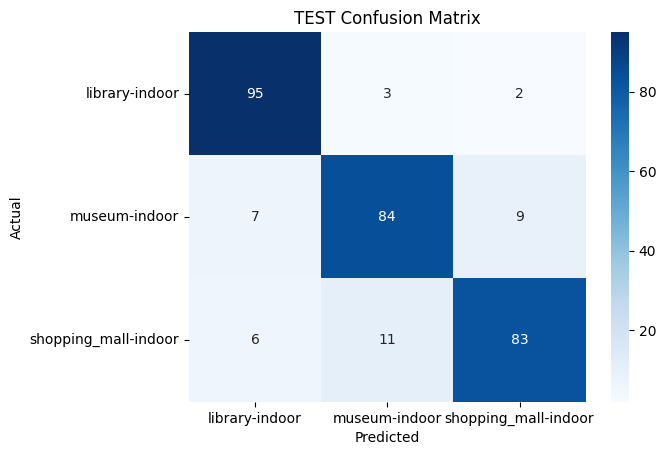


=== Training CompactVGG ===
Parameters: 1.17 M
Epoch  1/40 | lr 1.00e-03 | train loss 0.8462 acc  64.5% | valid loss 0.9806 acc  56.8% | best accuracy  56.8%
Epoch  2/40 | lr 1.00e-03 | train loss 0.6958 acc  74.2% | valid loss 0.7368 acc  72.0% | best accuracy  72.0%
Epoch  3/40 | lr 1.00e-03 | train loss 0.6317 acc  78.0% | valid loss 0.9802 acc  50.6% | best accuracy  72.0%
Epoch  4/40 | lr 1.00e-03 | train loss 0.6037 acc  79.3% | valid loss 0.6242 acc  77.7% | best accuracy  77.7%
Epoch  5/40 | lr 1.00e-03 | train loss 0.5785 acc  81.0% | valid loss 0.7457 acc  69.9% | best accuracy  77.7%
Epoch  6/40 | lr 1.00e-03 | train loss 0.5588 acc  81.8% | valid loss 0.9785 acc  68.7% | best accuracy  77.7%
Epoch  7/40 | lr 1.00e-03 | train loss 0.5392 acc  83.1% | valid loss 0.5650 acc  83.1% | best accuracy  83.1%
Epoch  8/40 | lr 1.00e-03 | train loss 0.5292 acc  83.7% | valid loss 0.5758 acc  82.4% | best accuracy  83.1%
Epoch  9/40 | lr 1.00e-03 | train loss 0.5193 acc  83.9% | valid

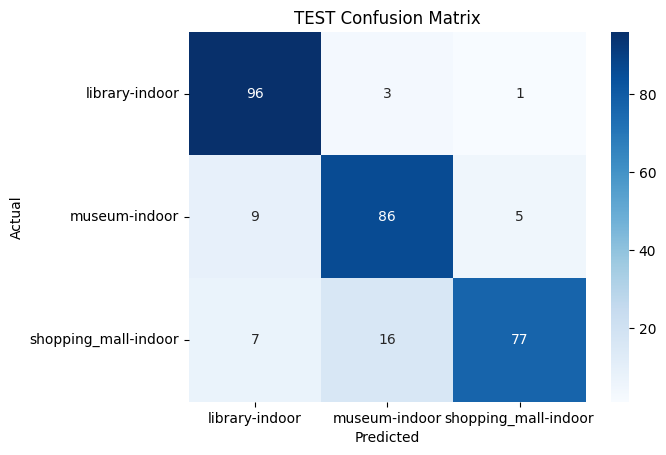


=== Training HybridModel ===
Parameters: 0.40 M
Epoch  1/40 | lr 1.00e-03 | train loss 0.8176 acc  66.7% | valid loss 0.8324 acc  69.5% | best accuracy  69.5%
Epoch  2/40 | lr 1.00e-03 | train loss 0.7115 acc  73.5% | valid loss 0.6932 acc  74.4% | best accuracy  74.4%
Epoch  3/40 | lr 1.00e-03 | train loss 0.6676 acc  76.0% | valid loss 1.0275 acc  58.0% | best accuracy  74.4%
Epoch  4/40 | lr 1.00e-03 | train loss 0.6385 acc  78.1% | valid loss 0.8913 acc  68.6% | best accuracy  74.4%
Epoch  5/40 | lr 1.00e-03 | train loss 0.6177 acc  78.5% | valid loss 1.3770 acc  57.9% | best accuracy  74.4%
Epoch  6/40 | lr 1.00e-03 | train loss 0.5981 acc  79.9% | valid loss 0.6826 acc  77.5% | best accuracy  77.5%
Epoch  7/40 | lr 1.00e-03 | train loss 0.5814 acc  80.7% | valid loss 0.6597 acc  75.7% | best accuracy  77.5%
Epoch  8/40 | lr 1.00e-03 | train loss 0.5723 acc  81.3% | valid loss 0.6912 acc  76.2% | best accuracy  77.5%
Epoch  9/40 | lr 1.00e-03 | train loss 0.5587 acc  82.2% | vali

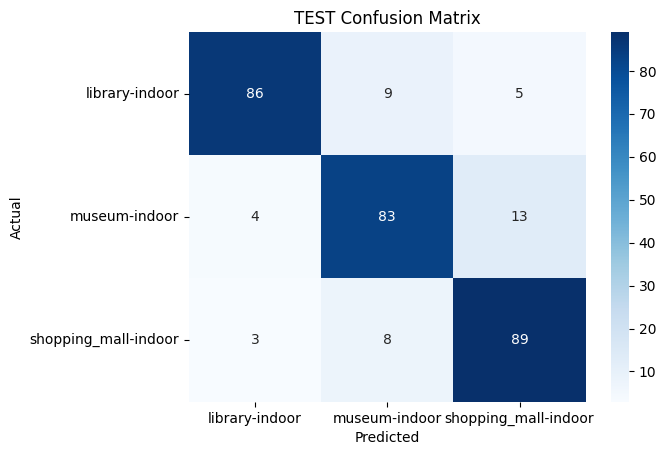

In [ ]:
architectures = OrderedDict({
    "CNN4x4"      : CNN(num_classes=3),
    "CompactVGG"  : CompactVGG(num_classes=3),
    "HybridModel" : HybridModel(num_classes=3)
})

baseline_metrics = []

for name, net in architectures.items():
    net = net.to(device)
    print(f"\n=== Training {name} ===")
    print(f"Parameters: {sum(p.numel() for p in net.parameters())/1e6:.2f} M")

    criterion  = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer  = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='max', factor=0.5, patience=3)

    best_val, ckpt_path = train(net, criterion, optimizer, scheduler,
                                num_epochs=40, patience=6)

    print(f"Evaluating {name} on TEST set")
    test_acc = evaluate(net, ckpt_path, test_loader)

    baseline_metrics.append(
        {"Model": name,
         "Val Acc": f"{best_val*100:.2f} %",
         "Test Acc": f"{test_acc*100:.2f} %",
         "Params (M)": f"{sum(p.numel() for p in net.parameters())/1e6:.2f}"}
    )

In [ ]:
df_base = pd.DataFrame(baseline_metrics)
print("\nBaseline summary")
print(df_base.to_markdown(index=False))


Baseline summary
| Model       | Val Acc   | Test Acc   |   Params (M) |
|:------------|:----------|:-----------|-------------:|
| CNN4x4      | 86.13 %   | 87.33 %    |         1.15 |
| CompactVGG  | 86.07 %   | 86.33 %    |         1.17 |
| HybridModel | 84.60 %   | 86.00 %    |         0.4  |


In [ ]:
drive_dir = "/content/drive/My Drive/COMP6721_Models/CNNs"
os.makedirs(drive_dir, exist_ok=True)

model_names = ["CNN", "CompactVGG", "HybridModel"]

for m in model_names:
    # pick newest file that starts with the model name
    paths = glob.glob(f"{m}*.pth")
    if not paths:
        print(f"No checkpoint found for {m}")
        continue
    best_ckpt = max(paths, key=os.path.getmtime)

    dst = os.path.join(drive_dir, os.path.basename(best_ckpt))
    shutil.copy2(best_ckpt, dst)
    print(f"Copied {best_ckpt}  →  {dst}")

print("All best checkpoints backed up to Drive.")

Copied CNN_bs64_lr3e-04.pth  →  /content/drive/My Drive/COMP6721_Models/CNNs/CNN_bs64_lr3e-04.pth
Copied CompactVGG_bs64_lr3e-04.pth  →  /content/drive/My Drive/COMP6721_Models/CNNs/CompactVGG_bs64_lr3e-04.pth
Copied HybridModel_bs64_lr3e-04.pth  →  /content/drive/My Drive/COMP6721_Models/CNNs/HybridModel_bs64_lr3e-04.pth
All best checkpoints backed up to Drive.


## Hyperparameter Tuning (Grid Search)

Based on the baseline performance, we select the lightweight CNN (`CNN4x4`) for hyperparameter tuning due to its efficiency and accuracy. We perform grid search over multiple learning rates and weight decay settings, identifying the best combination of hyperparameters.


In [ ]:
grid_lr = [3e-4, 7e-4, 1e-3]
grid_wd = [0.0, 1e-4]

Record = namedtuple("Record", "lr wd val_acc ckpt")
records = []

for lr in grid_lr:
    for wd in grid_wd:
        print(f"\n──── Grid run  lr={lr:g}  wd={wd:g} ────")
        model = CNN(num_classes=3).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
        opt       = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        sched     = torch.optim.lr_scheduler.ReduceLROnPlateau(
                        opt, mode='max', factor=0.5, patience=3)

        best_val, ckpt = train(model, criterion, opt, sched,
                               num_epochs=30, patience=6)   # returns (acc, ckpt)

        records.append(Record(lr, wd, best_val, ckpt))


──── Grid run  lr=0.0003  wd=0 ────
Epoch  1/30 | lr 3.00e-04 | train loss 0.8311 acc  65.1% | valid loss 0.7877 acc  69.1% | best accuracy  69.1%
Epoch  2/30 | lr 3.00e-04 | train loss 0.6929 acc  74.0% | valid loss 0.6816 acc  74.5% | best accuracy  74.5%
Epoch  3/30 | lr 3.00e-04 | train loss 0.6409 acc  77.1% | valid loss 0.9321 acc  63.0% | best accuracy  74.5%
Epoch  4/30 | lr 3.00e-04 | train loss 0.6034 acc  79.3% | valid loss 0.7120 acc  72.2% | best accuracy  74.5%
Epoch  5/30 | lr 3.00e-04 | train loss 0.5777 acc  80.9% | valid loss 0.7379 acc  71.7% | best accuracy  74.5%
Epoch  6/30 | lr 3.00e-04 | train loss 0.5523 acc  82.1% | valid loss 0.6179 acc  79.9% | best accuracy  79.9%
Epoch  7/30 | lr 3.00e-04 | train loss 0.5394 acc  82.8% | valid loss 0.5558 acc  83.4% | best accuracy  83.4%
Epoch  8/30 | lr 3.00e-04 | train loss 0.5269 acc  83.2% | valid loss 0.7481 acc  74.2% | best accuracy  83.4%
Epoch  9/30 | lr 3.00e-04 | train loss 0.5194 acc  83.8% | valid loss 0.626

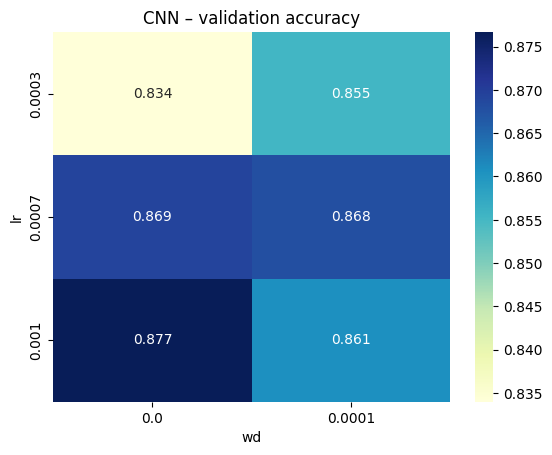

In [ ]:
# Validation heat-map
df = pd.DataFrame(records)
pivot = df.pivot(index="lr", columns="wd", values="val_acc")
sns.heatmap(pivot, annot=True, fmt=".003f", cmap="YlGnBu")
plt.title("CNN – validation accuracy")
plt.show()


Best hyper-params  lr=0.001  wd=0 (val_acc=0.8767)

TEST – classification metrics
                      precision    recall  f1-score   support

      library-indoor     0.8704    0.9400    0.9038       100
       museum-indoor     0.8830    0.8300    0.8557       100
shopping_mall-indoor     0.8776    0.8600    0.8687       100

            accuracy                         0.8767       300
           macro avg     0.8770    0.8767    0.8761       300
        weighted avg     0.8770    0.8767    0.8761       300



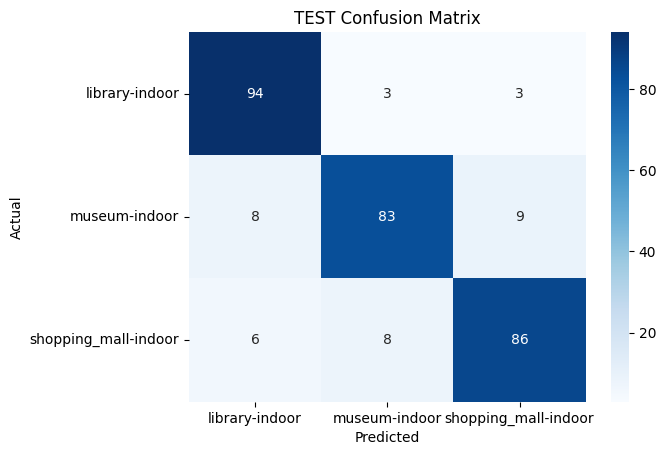

TEST accuracy = 87.67%


In [ ]:
# Evaluate the best checkpoint on TEST set
best_row = df.loc[df["val_acc"].idxmax()]
print(f"\nBest hyper-params  lr={best_row.lr:g}  wd={best_row.wd:g} "
      f"(val_acc={best_row.val_acc:.4f})")

best_model = CNN(num_classes=3).to(device)
test_acc   = evaluate(best_model, best_row.ckpt, test_loader)
print(f"TEST accuracy = {test_acc*100:.2f}%")

In [ ]:
df

,lr,wd,val_acc,ckpt
0,0.0003,0.0000,0.834000,CNN_bs64_lr3e-04.pth
1,0.0003,0.0001,0.855333,CNN_bs64_lr1e-04.pth
2,0.0007,0.0000,0.869333,CNN_bs64_lr9e-05.pth
3,0.0007,0.0001,0.868000,CNN_bs64_lr3e-04.pth
4,0.0010,0.0000,0.876667,CNN_bs64_lr3e-04.pth
5,0.0010,0.0001,0.860667,CNN_bs64_lr3e-04.pth


## Batch Size Tuning

To investigate the impact of batch size on model performance, we train the CNN model with batch sizes of 128 and 256, keeping other hyperparameters constant. This study highlights how batch size affects convergence, generalization, and training stability.


In [ ]:
batch_grid = [128, 256]
best_lr, best_wd = 1e-3, 0   # from previous grid

Record = namedtuple("Rec", "bs val_acc ckpt")
records_bs = []

for bs in batch_grid:
    print(f"\n── Batch size {bs} ──")

    # rebuild loaders with the new batch size
    train_loader = DataLoader(
        train_split,
        batch_size=bs,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    validation_loader = DataLoader(
        val_split,
        batch_size=bs,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )


    model = CNN(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
                opt, mode='max', factor=0.5, patience=3)


    best_val, ckpt = train(model, criterion, opt, sched,
                           num_epochs=30, patience=6)

    records_bs.append(Record(bs, best_val, ckpt))


── Batch size 128 ──
Epoch  1/30 | lr 1.00e-03 | train loss 0.9222 acc  60.8% | valid loss 0.9451 acc  56.9% | best accuracy  56.9%
Epoch  2/30 | lr 1.00e-03 | train loss 0.7214 acc  72.8% | valid loss 0.9030 acc  62.0% | best accuracy  62.0%
Epoch  3/30 | lr 1.00e-03 | train loss 0.6521 acc  77.0% | valid loss 0.6718 acc  75.7% | best accuracy  75.7%
Epoch  4/30 | lr 1.00e-03 | train loss 0.6040 acc  79.8% | valid loss 0.6206 acc  79.9% | best accuracy  79.9%
Epoch  5/30 | lr 1.00e-03 | train loss 0.5841 acc  80.6% | valid loss 1.0120 acc  58.7% | best accuracy  79.9%
Epoch  6/30 | lr 1.00e-03 | train loss 0.5599 acc  82.0% | valid loss 0.8733 acc  68.4% | best accuracy  79.9%
Epoch  7/30 | lr 1.00e-03 | train loss 0.5388 acc  82.6% | valid loss 0.8604 acc  69.5% | best accuracy  79.9%
Epoch  8/30 | lr 1.00e-03 | train loss 0.5269 acc  83.5% | valid loss 0.5660 acc  82.2% | best accuracy  82.2%
Epoch  9/30 | lr 1.00e-03 | train loss 0.5124 acc  84.5% | valid loss 0.6075 acc  80.4% | 


Best hyper-params  bs=128, lr=0.001, wd=0 (val_acc=85.8000)

TEST – classification metrics
                      precision    recall  f1-score   support

      library-indoor     0.9100    0.9100    0.9100       100
       museum-indoor     0.8776    0.8600    0.8687       100
shopping_mall-indoor     0.8725    0.8900    0.8812       100

            accuracy                         0.8867       300
           macro avg     0.8867    0.8867    0.8866       300
        weighted avg     0.8867    0.8867    0.8866       300



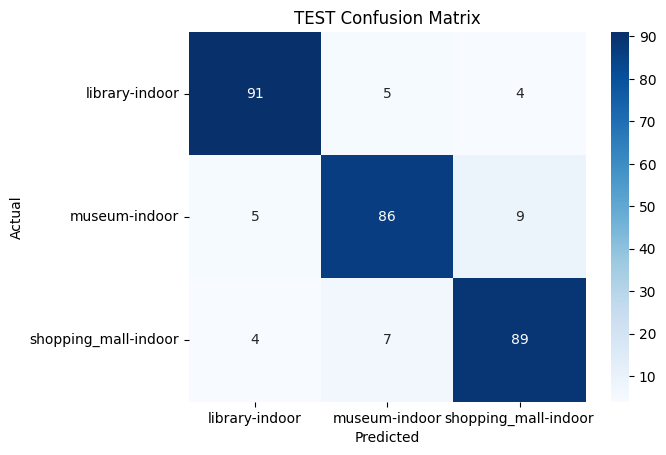

TEST accuracy = 88.67%


In [ ]:
# Evaluate the best checkpoint on TEST set
best_row = df.loc[df["val_acc"].idxmax()]
print(f"\nBest hyper-params  bs={best_row.bs:g}, lr={best_lr:g}, wd={best_wd:g} "
      f"(val_acc={best_row.val_acc:.4f})")

best_model = CNN(num_classes=3).to(device)
test_acc   = evaluate(best_model, best_row.ckpt, test_loader)
print(f"TEST accuracy = {test_acc*100:.2f}%")

##  Summary

We summarize and compare the performance of CNN models against classical machine learning methods (Phase 1), demonstrating the CNN’s superior capability in image feature extraction and classification.

| **Model**                         | **Train Acc (%)** | **Val Acc (%)** | **Test Acc (%)** |
| --------------------------------- | ----------------- | --------------- | ---------------- |
| **Classical ML Models (Phase 1)** |                   |                 |                  |
| RBF SVM                           | 98.8              | 73.5            | 75.3             |
| Linear SVM                        | 86.8              | 67.5            | 66.0             |
| Random Forest                     | 88.8              | 66.4            | 71.7             |
| DT (adaptive conf.)               | 61.9              | 59.4            | 61.0             |
| DT (fixed conf.)                  | 63.1              | 55.5            | 60.0             |
| **CNN Models (Phase 2)**          |                   |                 |                  |
| CNN4×4 (Baseline)                 | 95.2              | 86.1            | 87.3             |
| CompactVGG                        | 95.0              | 86.1            | 86.3             |
| HybridModel                       | 91.1              | 84.6            | 86.0             |
| CNN4×4 (Tuned)                    | 93.9              | 85.8            | 88.7             |
